In [84]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import pandas as pd
import numpy as np

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero, GATConv, Linear
# impoort HeteroData
from torch_geometric.data import HeteroData



1.13.1


In [85]:
# from torch_geometric.datasets import OGB_MAG
# import torch_geometric.transforms as T

# dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
# data = dataset[0]

# print(data.metadata())
# data['institution'].x.shape
# data.x

In [86]:
# create a tensor of 84 nodes that are empty
# x = torch.empty(84, 0)
# x[0][0]

In [87]:
def node_df_to_torch(df: pd.DataFrame):
    return torch.tensor(df.values, dtype=torch.float)

def edge_df_to_torch(df: pd.DataFrame):
    # assert edge_type in ["VarVal","ValOp", "OpVal"]
        return torch.tensor(df.index, dtype=torch.long).t().contiguous()

def problem_dfs(problem_path):
    """
    Returns the dataframes for the variables, values, operators, and their respective edges
    """
    variables_df = pd.read_csv(os.path.join(problem_path, 'variables.csv'), index_col=0)
    variables_df = variables_df.drop(columns=["is_goal"])
    
    values_df = pd.read_csv(os.path.join(problem_path, 'values.csv'), index_col=0)

    operators_df = pd.read_csv(os.path.join(problem_path, 'operators.csv'), index_col=0)

    val_var_df = pd.read_csv(os.path.join(problem_path, 'ValVar_edges.csv'), index_col=[0,1])
    val_op_df = pd.read_csv(os.path.join(problem_path, 'ValOp_edges.csv'), index_col=[0,1])
    val_op_df = val_op_df.drop(columns=["label"])
    op_val_df = pd.read_csv(os.path.join(problem_path, 'OpVal_edges.csv'), index_col=[0,1])
    op_val_df = op_val_df.drop(columns=["label"])

    return variables_df, values_df, operators_df, val_var_df, val_op_df, op_val_df

def build_hetero(
    variables_df,
    values_df,
    operators_df,
    val_var_df,
    val_op_df,
    op_val_df,
):
    hetero_data = HeteroData()
    hetero_data['variable'].x = node_df_to_torch(variables_df)
    hetero_data['value'].x = node_df_to_torch(values_df)
    hetero_data['operator'].x = x = torch.empty(len(operators_df), 0)
    hetero_data['operator'].y = node_df_to_torch(operators_df)

    hetero_data['variable', 'has_value', 'value'].edge_index = edge_df_to_torch(val_var_df)
    hetero_data['value', 'precondition', 'operator'].edge_index = edge_df_to_torch(val_op_df)
    hetero_data['operator', 'effect', 'value'].edge_index = edge_df_to_torch(op_val_df)

    # VarVal = edge_df_to_torch(val_var_df)
    # ValOp = edge_df_to_torch(val_op_df)
    # OpVal = edge_df_to_torch(op_val_df)


    # return hetero_data
    return T.ToUndirected()(hetero_data)


def build_data_set():
    path = "z_test_data" 
    dataset = []
    # dir_list = os.listdir("z_test_data")[:500]
    dir_list = os.listdir(path)
    for problem in dir_list:
        dfs = problem_dfs(os.path.join(path, problem))
        var_df, val_df, op_df, val_var_df, val_op_df, op_val_df = dfs
        temp_date = build_hetero(*dfs)
        dataset.append(temp_date)
    # dfs = problem_dfs(problem_path="z_test_data")
    # var_df, val_df, op_df, val_var_df, val_op_df, op_val_df = dfs
    # temp_date = build_hetero(*dfs)
    # dataset.append(temp_date)
    return dataset


def split_and_out_data_laoder():
    dataset = build_data_set()
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(0.25 * dataset_size))
    if True :
        np.random.seed(42)
        np.random.shuffle(indices)
    train_indices, test_indicies = indices[split:], indices[:split]
    
    train_set = []
    test_set = []

    for i in train_indices:
        train_set.append(dataset[i])
    for i in test_indicies:
        test_set.append(dataset[i])

    train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
    test_loader = train_loader
    # test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)
    # test_loader = test_set
    return train_loader, test_loader



In [113]:
train_loader, test_loader = split_and_out_data_laoder()
train_loader
odata = next(iter(train_loader))
odata["rev_precondition"]

{'edge_index': tensor([[0, 0, 1, 1, 2, 2, 2],
        [0, 5, 0, 2, 3, 1, 4]])}

In [114]:
odata["precondition"]

{'edge_index': tensor([[0, 5, 0, 2, 3, 1, 4],
        [0, 0, 1, 1, 2, 2, 2]])}

In [89]:


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        x = x.softmax()
        return x


model = GNN(hidden_channels=64, out_channels=1)
model = to_hetero(model, next(iter(train_loader)).metadata(), aggr='sum')
optimizer = torch.optim.Adam(model.parameters())

In [90]:
# print(out['operator'][0:10])
# print(our_data['operator'].y[0:10])

In [91]:
def train():
    model.train()

    for batch in train_loader:
        # print(f'test batch: {batch}')

        total_size = len(batch['operator'].y)
        # train_weights = torch.ones_(total_size).reshape(total_size,1)
        train_weights = torch.ones_like(batch['operator'].y)
        nunber_of_ones = batch['operator'].y.sum()
        nunber_of_zeros = total_size - nunber_of_ones
        train_weights[batch['operator'].y == 0] = nunber_of_ones/nunber_of_zeros
        train_weights[batch['operator'].y == 1] = nunber_of_zeros/nunber_of_ones
        # weight[batch['operator'].y == 0] = 1
        # weight[batch['operator'].y == 1] = 1
        # print(f'weight: {train_weights.shape}')
        # flattened = torch.flatten(train_weights, start_dim=total_size, end_dim=0)
        # flattened = torch.reshape(train_weights, (total_size, 1))
        # print(f'weight: {flattened.shape}')

        optimizer.zero_grad()
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.binary_cross_entropy(out['operator'],
                               batch['operator'].y, weight=train_weights)
        loss.backward()
        optimizer.step()
      

    return loss

@torch.no_grad()
def test():
    model.eval()
    i=0
    for batch in test_loader:
        # print(f'test batch: {batch}')
        total_size = len(batch['operator'].y)
        # test_weights = torch.ones(total_size).reshape(total_size,1)
        test_weights = torch.ones_like(batch['operator'].y)
        nunber_of_ones = batch['operator'].y.sum()
        nunber_of_zeros = total_size - nunber_of_ones
        test_weights[batch['operator'].y == 0] = nunber_of_ones/nunber_of_zeros
        test_weights[batch['operator'].y == 1] = nunber_of_zeros/nunber_of_ones
        assert i == 0

        # test_flattened = torch.reshape(test_weights, (total_size, 1))

        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.binary_cross_entropy(out['operator'],
                                batch['operator'].y, weight=test_weights)
        target = batch['operator'].y
        preds = out['operator']
        i+=1
    return loss, target, preds


def evaluate_and_return_confusion():
    model.eval()
    targets = []
    preds = []
    for batch in test_loader:
        out = model(batch.x_dict, batch.edge_index_dict)
        target = batch['operator'].y
        pred = out['operator']
        targets.append(target)
        preds.append(pred)
    return targets, preds


In [92]:
best_val_perf = test_perf = 0
epoch_list = []
loss_list = []
test_perf_list = []
target_conf = []
preds_conf = []
for epoch in range(1, 15):
    train_loss = train()

    test_perf, target, preds = test()
    target_conf.append(target)
    preds_conf.append(preds)
    # if val_perf > best_val_perf:
    #     best_val_perf = val_perf
    #     test_perf = tmp_test_perf
    # log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    log = 'Epoch: {:03d}, Loss: {:.4f}, Test: {:.4f}'

    epoch_list.append(epoch)
    loss_list.append(train_loss.item())
    test_perf_list.append(test_perf)

    if epoch % 1 == 0:

        print(log.format(epoch, train_loss, test_perf))

ValueError: Found indices in 'edge_index' that are larger than 0 (got 5). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 1) in your node feature matrix and try again.

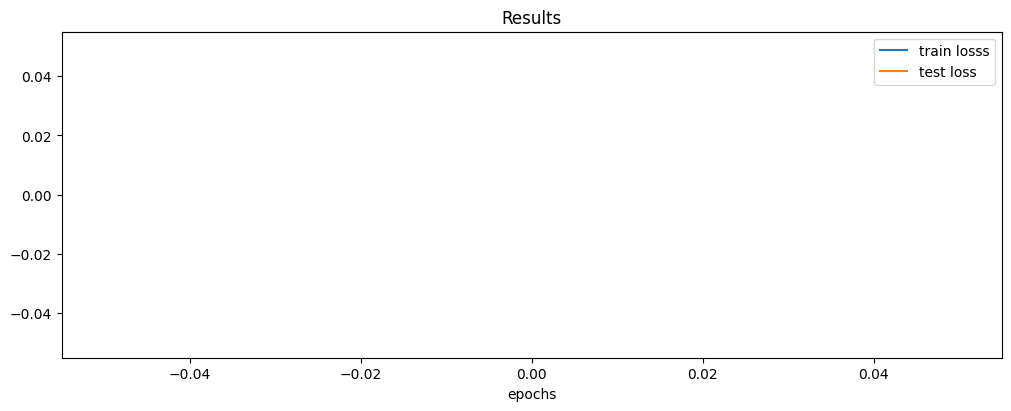

In [82]:
fig, ax = plt.subplots(figsize=(10, 4), layout='constrained')
ax.plot(epoch_list, loss_list, label='train losss')  
ax.plot(epoch_list, test_perf_list, label='test loss') 
ax.set_xlabel('epochs')  
ax.set_title("Results") 
ax.legend()

In [83]:
from torchmetrics.classification import BinaryConfusionMatrix

# target, preds = test()
# target_conf.append(target)
# preds_conf.append(preds)

loss, targets, preds = test()


# target, pred = evaluate_and_return_confusion()


target_final = torch.tensor(targets)
preds_final = torch.tensor(preds)
metric = BinaryConfusionMatrix()
# metric(preds_final, target_final)


from sklearn.metrics import confusion_matrix

# confusion_matrix([1,1,1], [0.99,0,0])
targets
print(preds >= 0.5)

preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

preds




ValueError: Found indices in 'edge_index' that are larger than 1 (got 5). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 2) in your node feature matrix and try again.

In [50]:
len(target_final)

110557

In [49]:
preds_final.round().count_nonzero()

tensor(110557)

In [51]:
confusion_matrix(target_final, target_final)

array([[103909,      0],
       [     0,   6648]])

In [12]:
test_set_size = len(targets)
print(f"test set size: {test_set_size}")
trues = targets.sum()

print(f"trues: {trues/test_set_size}")

ones = (targets == 1).sum()
print(f"ones: {ones/test_set_size}")


pred_test_size = len(preds)
print(f"pred test set size: {pred_test_size}")
pred_trues = preds.sum()
print(f"pred trues: {pred_trues/pred_test_size}")

test set size: 110557
trues: 0.06013187766075134
ones: 0.06013187766075134
pred test set size: 110557
pred trues: 0.9221007227897644


In [13]:
test_loader

In [14]:
# import torch.nn.functional as F

# def train():
#     for i in range(1, 100):
#         if i % 10 == 0:
#             print(f'Epoch: {i:03d}, Loss: {loss:.4f}')
#         model.train()
#         optimizer.zero_grad()
#         out = model(our_data.x_dict, our_data.edge_index_dict)

#         pred = out['operator']
#         true_label = our_data['operator'].y

#         print(pred[0])
#         # print(true_label)
#         loss = F.binary_cross_entropy_with_logits(pred, true_label)
#         loss.backward()
#         optimizer.step()
#         # return float(loss)

# train()

In [15]:
# def train():
#     model.train()

#     total_examples = total_loss = 0
#     for batch in train_loader:
#         optimizer.zero_grad()
#         batch = batch.to('cuda:0')
#         batch_size = batch['paper'].batch_size
#         out = model(batch.x_dict, batch.edge_index_dict)
#         loss = F.cross_entropy(out['paper'][:batch_size],
#                                batch['paper'].y[:batch_size])
#         loss.backward()
#         optimizer.step()

#         total_examples += batch_size
#         total_loss += float(loss) * batch_size

#     return total_loss / total_examples

In [16]:
# model.eval()

# out = model(our_data.x_dict, our_data.edge_index_dict)
# out["variable"]

In [21]:
b = [True, False, True]

a = torch.tensor([1,2,3])

a[b != True] = 7

train_weights[batch['operator'].y == 0] = nunber_of_ones/nunber_of_zeros
a

NameError: name 'nunber_of_ones' is not defined

In [70]:
batch = next(iter(train_loader))
batch['operator'].y

to_change = batch["operator"].y[:10]


weights  = torch.ones_like(to_change)

weights[to_change == 1] = 3
weights[to_change == 0] = 5

print(to_change)
print(weights)

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[3.],
        [3.],
        [3.],
        [5.],
        [5.],
        [5.],
        [3.],
        [3.],
        [3.],
        [3.]])


In [19]:
batch["operator"].y
train_weights = torch.ones(15).resize(15,1)
torch.flatten(train_weights)

/Users/piotrgzubicki/School/projectGNNs/GraphNeuralNetworks-ICAPS/.venv/lib/python3.9/site-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
total_size = 15
batch = next(iter(train_loader))
batch = batch[0]
test_weight = torch.ones(total_size).reshape(total_size,1)
test_weight[batch['operator'].y[0:15] == 0] = 15/5
torch.flatten(test_weight, -2)

x = torch.Tensor([1,2,3])
# batch